In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# -----------------------------
# 1. Reproducibility
# -----------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# 2. Dataset path
# -----------------------------
dataset_dir = r"C:\Users\chenn\OneDrive\Desktop\btp\dataset_btp"
csv_path = os.path.join(dataset_dir, "BTP_1_Dataset.csv")
df = pd.read_csv(csv_path)

# -----------------------------
# 3. Feature engineering
# -----------------------------
df["Power_to_Speed"] = df["Laser_Power"] / df["Scan_Speed"]
df["Energy_Density"] = df["Laser_Power"] / (df["Spot_Diameter"] * df["Scan_Speed"])
df["Flow_to_Cooling"] = df["Material_FlowRate"] / (df["Cooling_Rate"] + 1e-6)

df = df.drop(columns=['Stand_Off', 'Spot_Diameter', 'Material_FlowRate'])
df = pd.get_dummies(df, columns=['Material_Type'], prefix='Material')

numerical_features = ['Laser_Power', 'Scan_Speed', 'Cooling_Rate',
                      'Power_to_Speed', 'Energy_Density', 'Flow_to_Cooling']
categorical_features = [c for c in df.columns if c.startswith('Material_')]
features = numerical_features + categorical_features
targets = ['Aspect_Ratio', 'Dilution_Percent', 'PCE_Percent']

scaler_num = StandardScaler()
df[numerical_features] = scaler_num.fit_transform(df[numerical_features])

df['Images'] = df['Images'].astype(str)

# -----------------------------
# 4. Load images (RGB)
# -----------------------------
IMAGE_SIZE = (224, 224)

def load_raw_image(path):
    full_path = os.path.join(dataset_dir, path)
    img = load_img(full_path, target_size=IMAGE_SIZE, color_mode='rgb')
    img = img_to_array(img)
    if img.shape[-1] == 1:
        img = np.concatenate([img]*3, axis=-1)
    return img.astype(np.float32)

print("Loading images...")
image_raw = np.array([load_raw_image(p) for p in df['Images']], dtype=np.float32)
print("Loaded images shape:", image_raw.shape)

Loading images...
Loaded images shape: (27, 224, 224, 3)


In [3]:
# -----------------------------
# 5. Train/test split
# -----------------------------
X_num = df[features].values.astype(np.float32)
Y = df[targets].values.astype(np.float32)

X_num_train, X_num_test, X_img_train_raw, X_img_test_raw, Y_train_raw, Y_test_raw = train_test_split(
    X_num, image_raw, Y, test_size=0.2, random_state=SEED
)

scaler_target = StandardScaler()
Y_train = scaler_target.fit_transform(Y_train_raw)
Y_test = scaler_target.transform(Y_test_raw)

print("Train samples:", len(Y_train), "Test samples:", len(Y_test))

Train samples: 21 Test samples: 6


In [4]:
# -----------------------------
# 6. Image augmentation
# -----------------------------
batch_size = 16
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2,
    shear_range=0.15,
    fill_mode='reflect'
)

def multi_input_generator(X_num_arr, X_img_raw_arr, Y_arr, batch_size):
    n = len(Y_arr)
    indices = np.arange(n)
    while True:
        np.random.shuffle(indices)
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch_idx = indices[start:end]
            batch_num = X_num_arr[batch_idx]
            batch_img_raw = X_img_raw_arr[batch_idx]
            batch_img_aug_raw = np.array([img_datagen.random_transform(img) for img in batch_img_raw], dtype=np.float32)
            batch_img_aug = np.array([mobilenet_preprocess(img) for img in batch_img_aug_raw], dtype=np.float32)
            batch_y = Y_arr[batch_idx]
            yield ({'numerical_input': batch_num, 'image_input': batch_img_aug}, batch_y)

train_generator = multi_input_generator(X_num_train, X_img_train_raw, Y_train, batch_size)
steps_per_epoch = max(1, len(X_num_train) // batch_size)

X_img_test = np.array([mobilenet_preprocess(img) for img in X_img_test_raw], dtype=np.float32)
val_data = ({'numerical_input': X_num_test, 'image_input': X_img_test}, Y_test)

In [5]:
# -----------------------------
# 7. Build model
# -----------------------------
try:
    base_cnn = MobileNetV2(include_top=False, weights='imagenet', pooling='avg', input_shape=(224,224,3))
except:
    print("Failed to load ImageNet weights, using weights=None")
    base_cnn = MobileNetV2(include_top=False, weights=None, pooling='avg', input_shape=(224,224,3))

base_cnn.trainable = False

img_input = Input(shape=(224,224,3), name='image_input')
x_img = base_cnn(img_input)
x_img = BatchNormalization()(x_img)
x_img = Dropout(0.3)(x_img)

num_input = Input(shape=(X_num_train.shape[1],), name='numerical_input')
x_num = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(num_input)
x_num = BatchNormalization()(x_num)
x_num = Dropout(0.3)(x_num)
x_num = Dense(64, activation='relu')(x_num)

combined = Concatenate()([x_num, x_img])
x = Dense(64, activation='relu')(combined)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(len(targets), activation='linear', name='output')(x)

model = Model(inputs=[num_input, img_input], outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.Huber(),
    metrics=['mae']
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ numerical_input (InputLayer)  │ (None, 9)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │           1,280 │ numerical_input[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ image_input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 128)               │             512 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ mobilenetv2_1.00_224          │ (None, 1280)              │       2,257,984 │ image_input[0][0]          │
│ (Functional)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 1280)              │           5,120 │ mobilenetv2_1.00_224[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 1280)              │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 1344)              │               0 │ dense_1[0][0],             │
│                               │                           │                 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 64)                │          86,080 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 64)                │             256 │ dense_2[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64)                │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output (Dense)                │ (None, 3)                 │             195 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,359,683 (9.00 MB)

 Trainable params: 98,755 (385.76 KB)

 Non-trainable params: 2,260,928 (8.62 MB)

In [6]:
# -----------------------------
# 8. Train with frozen backbone
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=val_data,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# -----------------------------
# 9. Fine-tune last layers
# -----------------------------
for layer in base_cnn.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.Huber(),
    metrics=['mae']
)

history_fine = model.fit(
    train_generator,
    validation_data=val_data,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - loss: 1.1901 - mae: 1.6293 - val_loss: 0.9876 - val_mae: 1.3644 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.0642 - mae: 1.4919 - val_loss: 0.9782 - val_mae: 1.3559 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.3178 - mae: 1.7781 - val_loss: 0.9682 - val_mae: 1.3469 - learning_rate: 1.0000e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.7827 - mae: 1.2326 - val_loss: 0.9585 - val_mae: 1.3370 - learning_rate: 1.0000e-04
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.1063 - mae: 1.5499 - val_loss: 0.9484 - val_mae: 1.3278 - learning_rate: 1.0000e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step - loss: 0.9912 - mae: 1.4007 - val_loss: 0.9443 - val_mae: 1.3230 - learning_rate: 1.0000e-04
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step - loss: 1.3764 - mae: 1.8162 - val_loss: 0.9323 - val_mae: 1.3105 - learning_rate: 1.0000e-0

In [7]:
# -----------------------------
# 10. Prediction and evaluation
# -----------------------------
Y_pred_scaled = model.predict(val_data[0])
Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
Y_true = Y_test_raw

for i, target in enumerate(targets):
    mae = mean_absolute_error(Y_true[:, i], Y_pred[:, i])
    mse = mean_squared_error(Y_true[:, i], Y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_true[:, i], Y_pred[:, i])
    print(f"{target} Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Aspect_Ratio Metrics:
  MAE: 0.6120
  MSE: 0.4675
  RMSE: 0.6837
  R²: -2.2250
Dilution_Percent Metrics:
  MAE: 7.7021
  MSE: 71.1396
  RMSE: 8.4344
  R²: -0.9114
PCE_Percent Metrics:
  MAE: 7.3273
  MSE: 72.5896
  RMSE: 8.5200
  R²: 0.1826


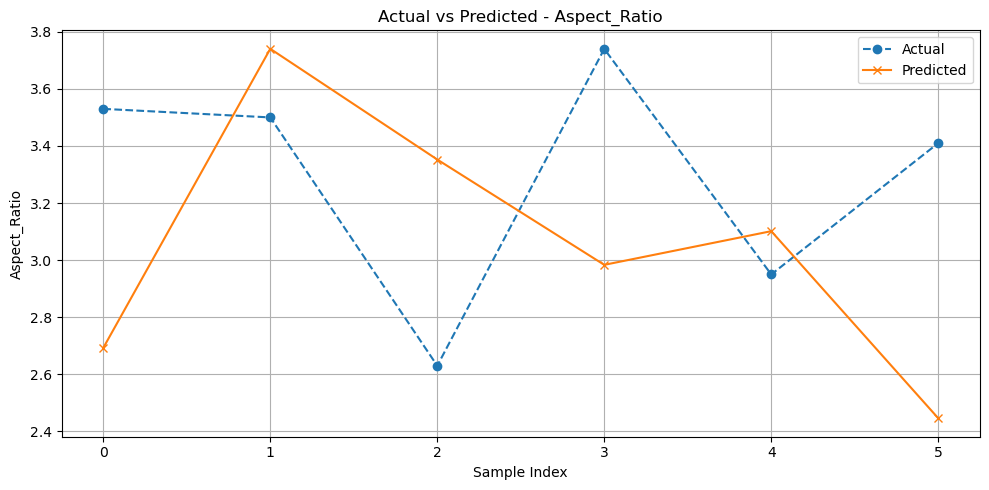

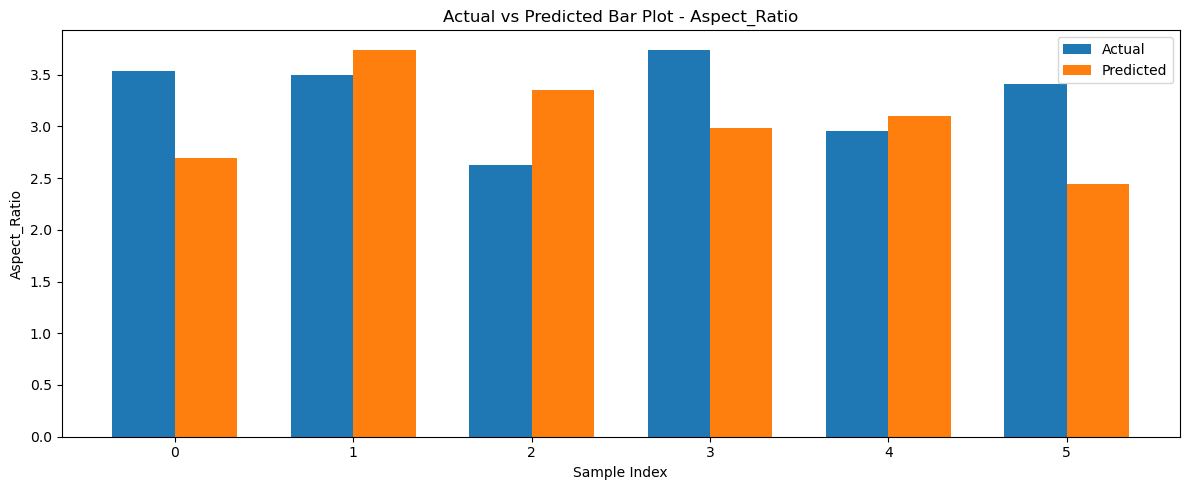

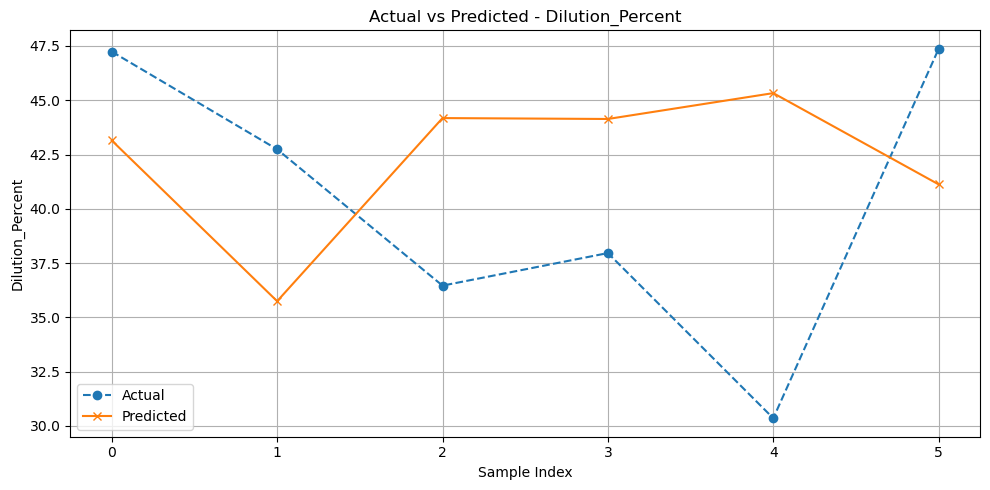

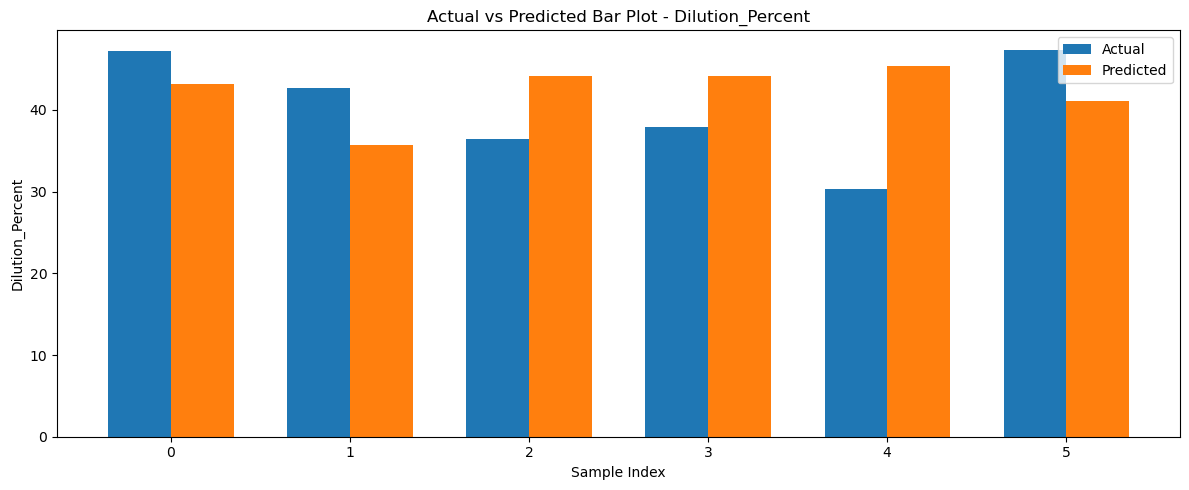

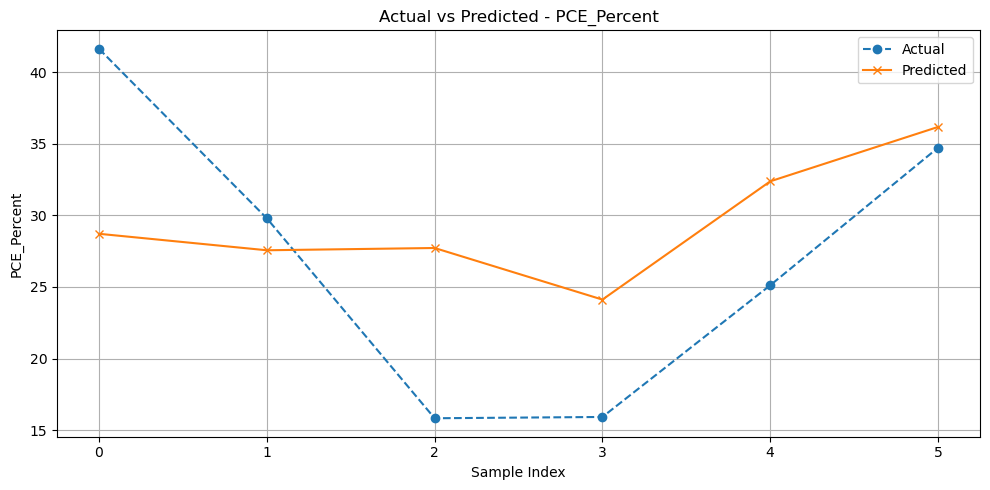

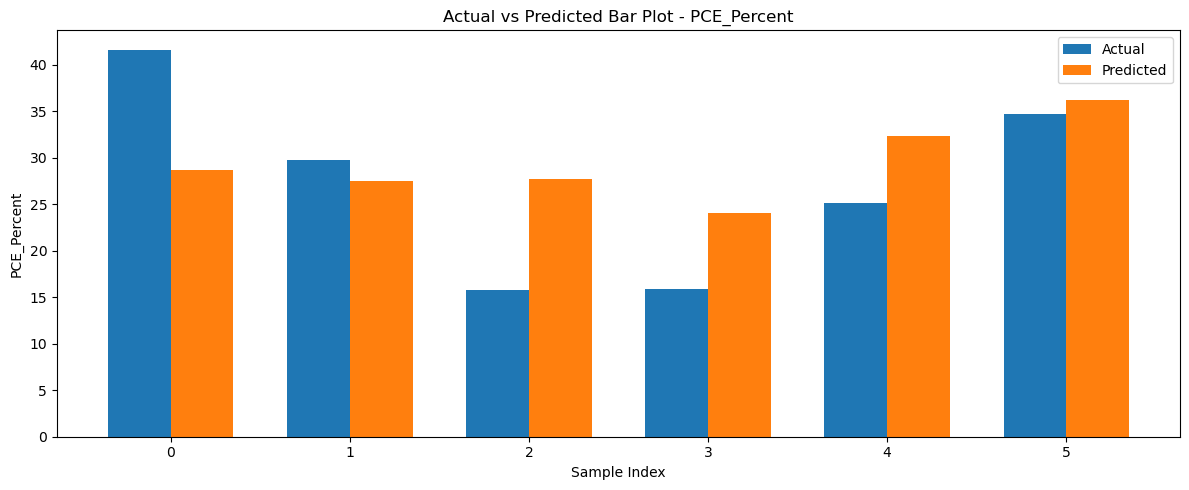

In [8]:
# -----------------------------
# 11. Visualization: Actual vs Predicted Line and Bar Plots
# -----------------------------
for i, target in enumerate(targets):
    plt.figure(figsize=(10,5))
    plt.plot(Y_true[:, i], label='Actual', marker='o', linestyle='--')
    plt.plot(Y_pred[:, i], label='Predicted', marker='x', linestyle='-')
    plt.title(f'Actual vs Predicted - {target}')
    plt.xlabel('Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    x = np.arange(len(Y_true[:, i]))
    width = 0.35

    plt.figure(figsize=(12,5))
    plt.bar(x - width/2, Y_true[:, i], width, label='Actual')
    plt.bar(x + width/2, Y_pred[:, i], width, label='Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted Bar Plot - {target}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
mse_total = np.mean((Y_test - Y_pred)**2)
print(f"Overall MSE (orig units): {mse_total:.4f}")

Overall MSE (orig units): 920.7933


In [11]:
# -----------------------------
#  Save model
# -----------------------------
model.save("early_fusion_mobilenetv2.keras")